# Lesson 06
# Peter Lorenz

In this assignment, we build a model to predict whether an individual is a PEP (politically exposed person) based on their banking data.

## <font color='red'>IMPORTANT!!!</font>
<font color='red'>**Please customize to correct local path before running this notebook:**</font>

In [103]:
# IMPORTANT: Set GRAPHVIZ_PATH to correct local path!
#GRAPHVIZ_PATH = 'C:/Users/Pete/Anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin/graphviz'
GRAPHVIZ_PATH = 'C:/Users/ross/Anaconda3/envs/uwdatasci420/Library/bin/graphviz'

## 0. Preliminaries

Import the required libraries:

In [141]:
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

Set global options:

In [2]:
# Display plots inline
%matplotlib inline

# Display multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Declare utility functions:

In [129]:
# Utility functions
def show_tree(out_name, model, feature_names):
    dotfile = open(out_name + ".dot", 'w')
    tree.export_graphviz(model, out_file = dotfile, filled = True, rounded = True, 
                         feature_names = feature_names)
    dotfile.close()

    os.environ["PATH"] += os.pathsep + GRAPHVIZ_PATH
    os.system('dot -Tpng {}.dot -o {}.png'.format(out_name, out_name))

    return(Image(filename = out_name + '.png', width = 2000, height = 2000))

## 1. Read, parse, and pre-process the data
In this section, we read, parse, and pre-process the data.

In [81]:
# Internet location of the data set
url = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Bank%20Data.csv"

# Download the data into a dataframe object
bank_data = pd.read_csv(url)

# Display shape and initial data
bank_data.shape
bank_data.head()

# Examine column types
bank_data.info()

(600, 11)

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,FEMALE,INNER_CITY,17546.000,NO,1,NO,NO,NO,NO,YES
1,40,MALE,TOWN,30085.100,YES,3,YES,NO,YES,YES,NO
2,51,FEMALE,INNER_CITY,16575.400,YES,0,YES,YES,YES,NO,NO
3,23,FEMALE,TOWN,20375.400,YES,3,NO,NO,YES,NO,NO
4,57,FEMALE,RURAL,50576.300,YES,0,NO,YES,NO,NO,NO


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          600 non-null    int64  
 1   sex          600 non-null    object 
 2   region       600 non-null    object 
 3   income       600 non-null    float64
 4   married      600 non-null    object 
 5   children     600 non-null    int64  
 6   car          600 non-null    object 
 7   save_act     600 non-null    object 
 8   current_act  600 non-null    object 
 9   mortgage     600 non-null    object 
 10  pep          600 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 51.7+ KB


First we have to deal with categorical columns, converting these to one-hot-encoded format:

In [82]:
# Use pandas to one-hot encode binary variables, excluding the inverse column
bank_data_enc = pd.get_dummies(bank_data, 
                               columns=["sex", "married", "car", 
                                        "save_act", "current_act", "mortgage", "pep"], 
                               drop_first=True)

# Use pandas to one-hot encode categorical variables, including one column per value
bank_data_enc = pd.get_dummies(bank_data_enc, 
                               columns=["region", "children"])

# Display shape and sample contents
bank_data_enc.shape
bank_data_enc.head()

# Examine column types
bank_data_enc.info()

(600, 17)

,age,income,sex_MALE,married_YES,car_YES,save_act_YES,current_act_YES,mortgage_YES,pep_YES,region_INNER_CITY,region_RURAL,region_SUBURBAN,region_TOWN,children_0,children_1,children_2,children_3
0,48,17546.000,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
1,40,30085.100,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1
2,51,16575.400,0,1,1,1,1,0,0,1,0,0,0,1,0,0,0
3,23,20375.400,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1
4,57,50576.300,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                600 non-null    int64  
 1   income             600 non-null    float64
 2   sex_MALE           600 non-null    uint8  
 3   married_YES        600 non-null    uint8  
 4   car_YES            600 non-null    uint8  
 5   save_act_YES       600 non-null    uint8  
 6   current_act_YES    600 non-null    uint8  
 7   mortgage_YES       600 non-null    uint8  
 8   pep_YES            600 non-null    uint8  
 9   region_INNER_CITY  600 non-null    uint8  
 10  region_RURAL       600 non-null    uint8  
 11  region_SUBURBAN    600 non-null    uint8  
 12  region_TOWN        600 non-null    uint8  
 13  children_0         600 non-null    uint8  
 14  children_1         600 non-null    uint8  
 15  children_2         600 non-null    uint8  
 16  children_3         600 non

One challenge is how to represent the age column in our data set. The column is sequential and, hence, an age of 42 is more related to an age of 41 than, say, an age of 20. Yet the column is also categorical in that a person who is 40 is not in any sense "twice" a person who is 20. It seems preferable to represent age as a series of bins. First we determine the range of ages:

In [83]:
# Display max and min ages
print('Min age is', bank_data_enc['age'].min())
print('Max age is', bank_data_enc['age'].max())

Min age is 18
Max age is 67


The range of ages is essentially the "working" ages from 18 to 67. One straightforward way to bin the data is by decade: 20's, 30's, 40's, 50's, 60's. For convenience, we combine ages 18 and 19 with the 20's.

In [84]:
# Bin age by decade
bank_data_enc['is_twenties'] = np.array((bank_data_enc['age'] >= 18).astype(int) & 
                                        (bank_data_enc['age'] < 30).astype(int))
bank_data_enc['is_thirties'] = np.array((bank_data_enc['age'] >= 30).astype(int) & 
                                        (bank_data_enc['age'] < 40).astype(int))
bank_data_enc['is_forties'] = np.array((bank_data_enc['age'] >= 40).astype(int) & 
                                       (bank_data_enc['age'] < 50).astype(int))
bank_data_enc['is_fifties'] = np.array((bank_data_enc['age'] >= 50).astype(int) & 
                                        (bank_data_enc['age'] < 60).astype(int))
bank_data_enc['is_sixties'] = np.array((bank_data_enc['age'] >= 60).astype(int))

# Display shape and sample contents
bank_data_enc.shape
bank_data_enc.head()

# Examine column types
bank_data_enc.info()

(600, 22)

,age,income,sex_MALE,married_YES,car_YES,save_act_YES,current_act_YES,mortgage_YES,pep_YES,region_INNER_CITY,...,region_TOWN,children_0,children_1,children_2,children_3,is_twenties,is_thirties,is_forties,is_fifties,is_sixties
0,48,17546.000,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,0
1,40,30085.100,1,1,1,0,1,1,0,0,...,1,0,0,0,1,0,0,1,0,0
2,51,16575.400,0,1,1,1,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
3,23,20375.400,0,1,0,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0
4,57,50576.300,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                600 non-null    int64  
 1   income             600 non-null    float64
 2   sex_MALE           600 non-null    uint8  
 3   married_YES        600 non-null    uint8  
 4   car_YES            600 non-null    uint8  
 5   save_act_YES       600 non-null    uint8  
 6   current_act_YES    600 non-null    uint8  
 7   mortgage_YES       600 non-null    uint8  
 8   pep_YES            600 non-null    uint8  
 9   region_INNER_CITY  600 non-null    uint8  
 10  region_RURAL       600 non-null    uint8  
 11  region_SUBURBAN    600 non-null    uint8  
 12  region_TOWN        600 non-null    uint8  
 13  children_0         600 non-null    uint8  
 14  children_1         600 non-null    uint8  
 15  children_2         600 non-null    uint8  
 16  children_3         600 non

We lose some information concerning the sequential nature of the data, but avoid the meaninglessness of implying that numerical operations apply to ages. We now drop the original age column:

In [85]:
# Drop age column
bank_data_enc = bank_data_enc.drop(['age'], axis=1)

# Display shape and sample contents
bank_data_enc.shape
bank_data_enc.head()

# Examine column types
bank_data_enc.info()

(600, 21)

,income,sex_MALE,married_YES,car_YES,save_act_YES,current_act_YES,mortgage_YES,pep_YES,region_INNER_CITY,region_RURAL,...,region_TOWN,children_0,children_1,children_2,children_3,is_twenties,is_thirties,is_forties,is_fifties,is_sixties
0,17546.000,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,1,0,0
1,30085.100,1,1,1,0,1,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
2,16575.400,0,1,1,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
3,20375.400,0,1,0,0,1,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
4,50576.300,0,1,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   income             600 non-null    float64
 1   sex_MALE           600 non-null    uint8  
 2   married_YES        600 non-null    uint8  
 3   car_YES            600 non-null    uint8  
 4   save_act_YES       600 non-null    uint8  
 5   current_act_YES    600 non-null    uint8  
 6   mortgage_YES       600 non-null    uint8  
 7   pep_YES            600 non-null    uint8  
 8   region_INNER_CITY  600 non-null    uint8  
 9   region_RURAL       600 non-null    uint8  
 10  region_SUBURBAN    600 non-null    uint8  
 11  region_TOWN        600 non-null    uint8  
 12  children_0         600 non-null    uint8  
 13  children_1         600 non-null    uint8  
 14  children_2         600 non-null    uint8  
 15  children_3         600 non-null    uint8  
 16  is_twenties        600 non

Next we extract the target variable:

In [86]:
# Extract and reserve the target column
is_pep = np.array(bank_data_enc['pep_YES'].values)
bank_data_enc = bank_data_enc.drop(['pep_YES'], axis=1)

We can now proceed to exploratory analysis.

## 2. Perform exploratory analysis
In this section, we perform a brief exploratory analysis, beginning with an analysis of column distributions.
### Column distributions
Here we examine the column distributions per column.

#### Income

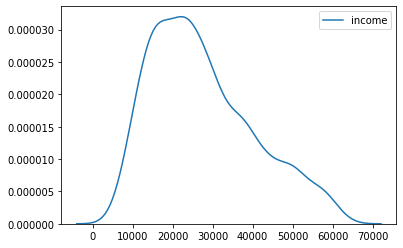

In [87]:
sns.kdeplot(bank_data_enc['income'], bw = 3000)

We find that income is positively skewed with a peak around 20K.

#### Sex

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Is Male?')]

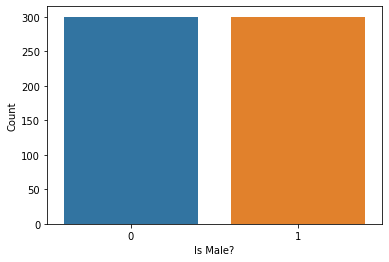

In [88]:
# Plot distribution by sex
ax = sns.countplot(x='sex_MALE', data=bank_data_enc)
ax.set(xlabel='Is Male?', ylabel='Count')

The data set has an equal number of males and females.

#### Age

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Age Group')]

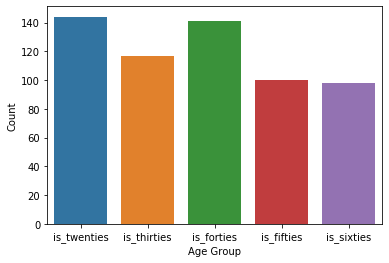

In [91]:
# Plot distribution by age group
df = pd.melt(bank_data_enc[['is_twenties', 'is_thirties', 'is_forties', 'is_fifties', 'is_sixties']])
ax = sns.countplot(data=df.loc[df['value']!=0], x='variable')
ax.set(xlabel='Age Group', ylabel='Count')

The age groups are fairly evenly distributed, with most customers in their twenties or forties (note, however, that the twenties group also includes 18 and 19 year olds). Fewer customers are in their fifties and sixties respectively.

#### Region Category

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Region Category')]

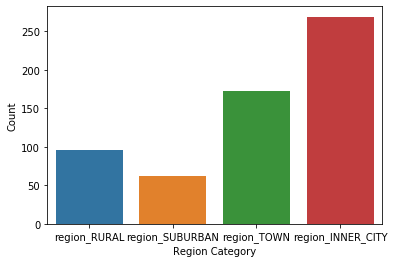

In [93]:
# Plot distribution by region
df = pd.melt(bank_data_enc[['region_RURAL', 'region_SUBURBAN', 'region_TOWN', 'region_INNER_CITY']])
ax = sns.countplot(data=df.loc[df['value']!=0], x='variable')
ax.set(xlabel='Region Category', ylabel='Count')

The plot of customers by region shows that most live in the inner city followed by towns, while fewer live in rural areas and still fewer in suburban areas.

#### Number of Children

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Number of children')]

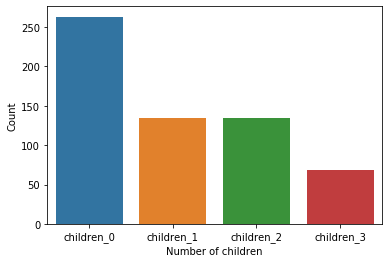

In [94]:
# Plot distribution by number of children
df = pd.melt(bank_data_enc[['children_0', 'children_1', 'children_2', 'children_3']])
ax = sns.countplot(data=df.loc[df['value']!=0], x='variable')
ax.set(xlabel='Number of children', ylabel='Count')

Most customers have no children, while about half of the number with no children have one or two children respectively. The fewest number of customers have three children.

#### Car Ownership

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Owns a car?')]

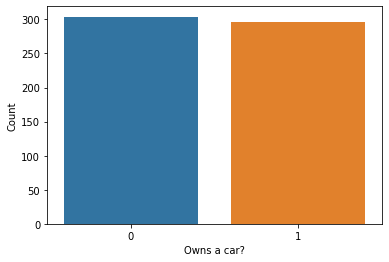

In [95]:
# Plot distribution by car ownership
ax = sns.countplot(x='car_YES', data=bank_data_enc)
ax.set(xlabel='Owns a car?', ylabel='Count')

Approximately equal numbers of customers own a car as do not own a car.

### Account and Mortgage Status

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Account and Mortgage Status')]

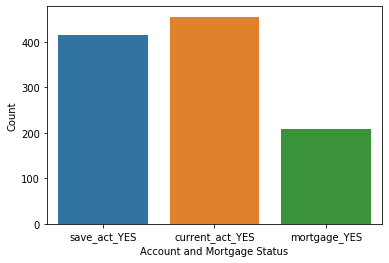

In [96]:
# Plot distribution by account ownership and possession of a mortgage
df = pd.melt(bank_data_enc[['save_act_YES', 'current_act_YES', 'mortgage_YES']])
ax = sns.countplot(data=df.loc[df['value']!=0], x='variable')

ax.set(xlabel='Account and Mortgage Status', ylabel='Count')

Roughly two thirds of customers have a savings account, while slightly more have a current account. Roughly one third has a mortgage.

#### PEP Status

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Is Politically Exposed?')]

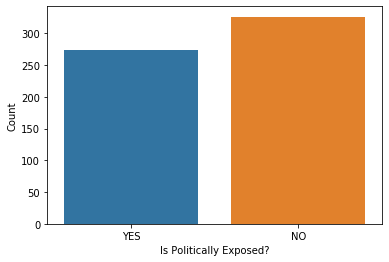

In [99]:
# Plot distribution by PEP status
ax = sns.countplot(x='pep', data=bank_data)
ax.set(xlabel='Is Politically Exposed?', ylabel='Count')

Interestingly, about equal numbers of the banks customers have political exposure. Given these roughly proportionate outcomes, it is unnecessary to balance the data set.

## 3. Compare the performance of decision tree and random forest approaches
In this section, we compare the performance between a decision tree and a random forest approach by assessing the accuracy of each model. We first split the data set into training and test. To use as much data as possible for our model, we reserve only 50 rows as test data:

In [102]:
# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(bank_data_enc, 
                                                    is_pep, 
                                                    test_size = 0.0833, # 50 rows
                                                    random_state = 0)

### Decision Tree
Our first model is a decision tree model. Using the gini coefficient, we begin by identifying the optimal value for the max_depth hyperparameter:

In [114]:
# Range of values to test (both methods)
param_grid = {'max_depth': np.arange(3, 15)}

# Search trees under specified range of values
tree_dt = GridSearchCV(DecisionTreeClassifier(criterion = 'gini', 
                                              random_state=0), 
                       param_grid)

# Fit model under optimal parameters
tree_dt.fit(X_train, y_train)
tree_pred_dt = tree_dt.predict(X_test)
tree_perf_dt = roc_auc_score(y_test, tree_pred_dt)

# Display optimal parameters
print('Optimal max depth: ', tree_dt.best_params_['max_depth'])

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
             pre_dispatch='2

Optimal max depth:  6


array([[21,  2],
       [ 5, 22]], dtype=int64)

              precision    recall  f1-score   support

           0       0.81      0.91      0.86        23
           1       0.92      0.81      0.86        27

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.87      0.86      0.86        50



We now build our model using the optimal max_depth of 6 and display the confusion matrix and accuracy metrics:

In [116]:
# Construct decision tree classifier
bank_dt = DecisionTreeClassifier(criterion = 'gini', max_depth = 6, random_state=0)
bank_dt.fit(X_train, y_train)

# Display tree depth
print('Max depth:', bank_dt.tree_.max_depth)

# Predict based on test data
y_pred_test_dt = bank_dt.predict(X_test)

# Display confusion matrix
confusion_matrix(y_test, tree_pred_dt)

# Display performance metrics
print(classification_report(y_test, tree_pred_dt))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Max depth: 6


array([[21,  2],
       [ 5, 22]], dtype=int64)

              precision    recall  f1-score   support

           0       0.81      0.91      0.86        23
           1       0.92      0.81      0.86        27

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.87      0.86      0.86        50



The recall of our model is just 0.81. Out of 27 positives in our test data, just 22 were correctly identified.

### Random Forest
Now we build a random forest model. We begin by finding the optimal values of the n_estimators and max_depth hyperparameters:

In [137]:
# Range of values to test (both methods)
param_grid = { 'n_estimators': np.arange(10, 100, 10),
               'max_depth': np.arange(4, 12, 2)}

# Search trees under specified range of values
gs = GridSearchCV(RandomForestClassifier(verbose=0, random_state=0), 
                  param_grid)

# Fit model under optimal parameters
gs.fit(X_train, y_train)
gs_pred = gs.predict(X_test)
gs_perf = roc_auc_score(y_test, gs_pred)

# Display optimal parameters
print('Optimal number of estimators: ', gs.best_params_['n_estimators'])
print('Optimal max depth: ', gs.best_params_['max_depth'])

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                

Optimal number of estimators:  40
Optimal max depth:  8


Our search of hyperparameter values identified 40 as the optimal value for the n_estimators and 8 as the optimal max_depth. Now we are ready to build our model using these parameters:

In [140]:
# Build random forest model
clf = RandomForestClassifier(n_estimators=40, max_depth=8, random_state=0, verbose=0)
clf.fit(X_train, y_train)

# Generate predictions
pred_rf = clf.predict(X_test)

# Display feature importance per feature
print(clf.feature_importances_)

# Display confusion matrix
confusion_matrix(y_test, pred_rf)

# Display performance metrics
print(classification_report(y_test, pred_rf))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

[0.252 0.024 0.082 0.025 0.043 0.025 0.064 0.019 0.018 0.017 0.025 0.062
 0.16  0.034 0.044 0.032 0.014 0.02  0.015 0.023]


array([[22,  1],
       [ 8, 19]], dtype=int64)

              precision    recall  f1-score   support

           0       0.73      0.96      0.83        23
           1       0.95      0.70      0.81        27

    accuracy                           0.82        50
   macro avg       0.84      0.83      0.82        50
weighted avg       0.85      0.82      0.82        50



The performance is not great. In fact, it is worse than the performance of our decision tree. So we turn to gradient boosting as a way to improve our model. We start by identifying optimal hyperparameters:

In [142]:
# Range of values to test (both methods)
param_grid = { 'n_estimators': np.arange(10, 100, 10),
               'learning_rate': np.arange(0.05, 0.1, 0.05), 
               'max_depth': np.arange(4, 12, 2)}

# Search trees under specified range of values
gs = GridSearchCV(GradientBoostingClassifier(loss='deviance', verbose=0, random_state=0), 
                  param_grid)

# Fit model under optimal parameters
gs.fit(X_train, y_train)
gs_pred = gs.predict(X_test)
gs_perf = roc_auc_score(y_test, gs_pred)

# Display optimal parameters
print('Optimal number of estimators: ', gs.best_params_['n_estimators'])
print('Optimal learning rate (shrinkage): ', gs.best_params_['learning_rate'])
print('Optimal max depth: ', gs.best_params_['max_depth'])

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_n...,
                

Optimal number of estimators:  90
Optimal learning rate (shrinkage):  0.05
Optimal max depth:  4


Our search of hyperparameter values identified 90 as the optimal value for the n_estimators, 0.05 as the optimal shrinkage, and 4 as the optimal max_depth. Now we are ready to build our model:

In [145]:
# Construct and fit model using gradient boosting
gbm_clf = GradientBoostingClassifier(n_estimators=90, loss='deviance', 
                                     learning_rate=0.05, max_depth=4)
gbm_clf.fit(X_train, y_train)

# Display feature importances
print(gbm_clf.feature_importances_)

# Generate predictions
pred_gb = gbm_clf.predict(X_test)

# Display confusion matrix
cm_gb = confusion_matrix(y_test, pred_gb)

# Display performance metrics
print(classification_report(y_test, pred_gb))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=90,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

[0.309 0.003 0.08  0.006 0.063 0.005 0.08  0.003 0.001 0.01  0.009 0.122
 0.208 0.067 0.013 0.    0.002 0.005 0.007 0.005]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        23
           1       0.96      0.85      0.90        27

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.91      0.90      0.90        50



With gradient boosting, our model is now up to 0.85 recall and 0.9 accuracy, both performance improvements over our decision tree.

## 4. Graph structure of the decision tree
In this section, we graph the structure of our decision tree.

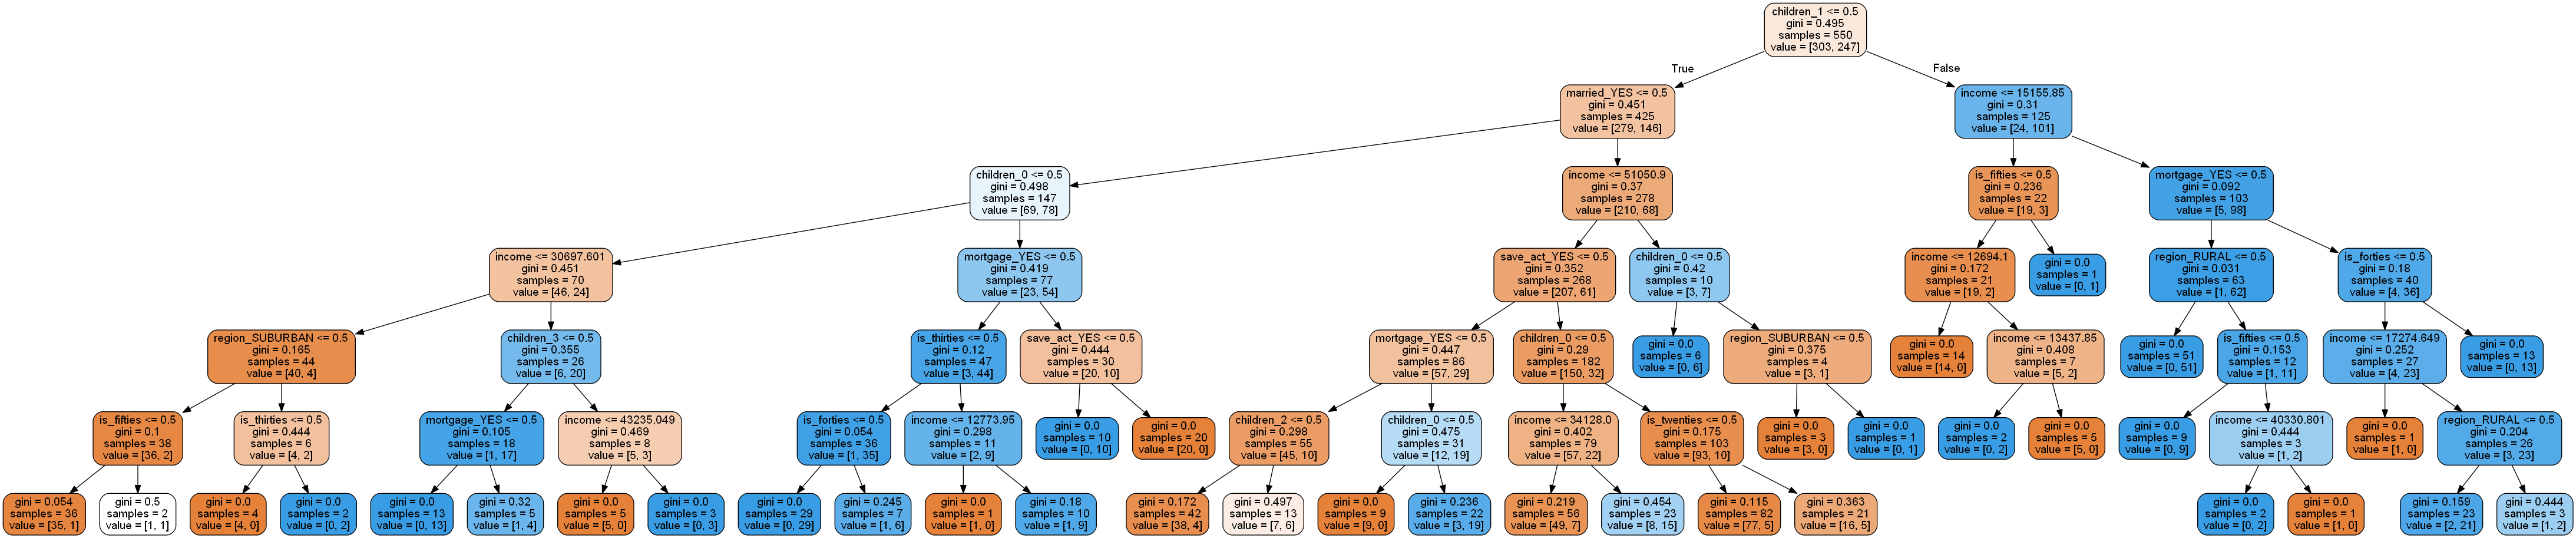

In [130]:
# Display tree
show_tree('decision_tree', bank_dt, X_train.columns)

In our decision tree, the features are selected in the following order:

1. Level 1: children_1
1. Level 2: married_YES, income
1. Level 3: children_0, income, is_fifties, mortgage_YES
1. Level 4: income, mortgage_YES, save_act_YES, children_0, region_RURAL, is_forties
etc.

There is no need to go through more. The chaotic mix of criteria at each level and the fact that so many features are selected at each level with no apparent pattern suggests that the model has fit itself rather tightly around the training data. But herein lies the problem. The model is clearly overfit to the specificities of the training set. It is unlikely that this model generalizes to other data sets with the same features. This explains the rather poor recall on the test data set.

## 5. Graph the confusion matrix of your random forest model
In this section, we graph the confusion matrix of our random forest model:

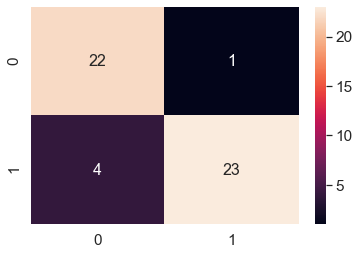

In [146]:
# Graph the confusion matrix
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_gb, annot=True, annot_kws={"size": 16}) # font size
plt.show()

From the confusion matrix, we find that of the 27 positives in our test data, 23 were correctly identified as such. Of 23 negatives in our test data, 22 were correctly identified.

## Summary
In this assignment, we compared the performance of a decision tree classifier against that of a random forest classifier. We found that the random forest did not perform as well as the decision tree, so we then attempted gradient boosting. We found that the gradient boosting classifier outperformed both the decision tree classifier and the random forest classifier.